# Grid algorithm for the gamma-Poisson hierarchical model

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [4]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [5]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [6]:
def decorate_heads(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of heads (k)')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    legend()

In [7]:
def decorate_proportion(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    legend()

## Poisson model

Let's look at one more example of a hierarchical model, based on the hockey example we started with.

Remember that we used a gamma distribution to represent the distribution of the rate parameters, `mu`.
I chose the parameters of that distribution, `alpha` and `beta`, based on results from previous NHL playoff games.

An alternative is to use a hierarchical model, where `alpha` and `beta` are hyperparameters.  Then we can use data to update estimate the distribution of `mu` for each team, and to estimate the distribution of `mu` across teams.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

Here's a model that generates the prior distribution of `mu`.

In [8]:
def decorate_rate(ylabel='Density'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    legend()

## One teams

Here's the hierarchical version of the model for two teams.

In [81]:
import pymc3 as pm

with pm.Model() as model7:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_A = pm.Gamma('mu_A', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    trace7 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


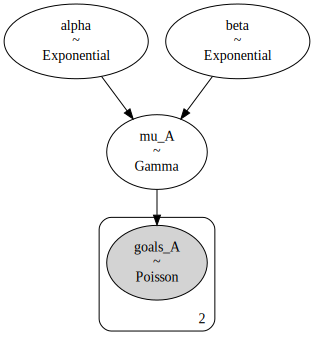

In [82]:
pm.model_to_graphviz(model7)

We can use `traceplot` to review the results and do some visual diagnostics.

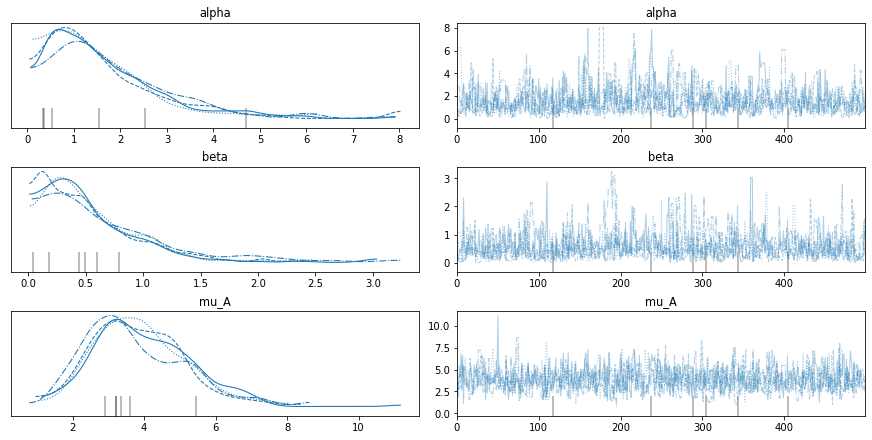

In [83]:
import arviz as az

with model7:
    az.plot_trace(trace7)

Here are the posterior distributions for the two teams.

In [12]:
mu_A = trace7['mu_A']
mu_B = trace7['mu_B']
mu_B.mean(), mu_A.mean()

(1.314995969729836, 3.570805676766087)

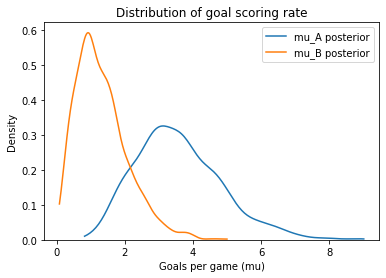

In [13]:
plot_kde(mu_A, label='mu_A posterior')
plot_kde(mu_B, label='mu_B posterior')
decorate_rate('Density')

array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

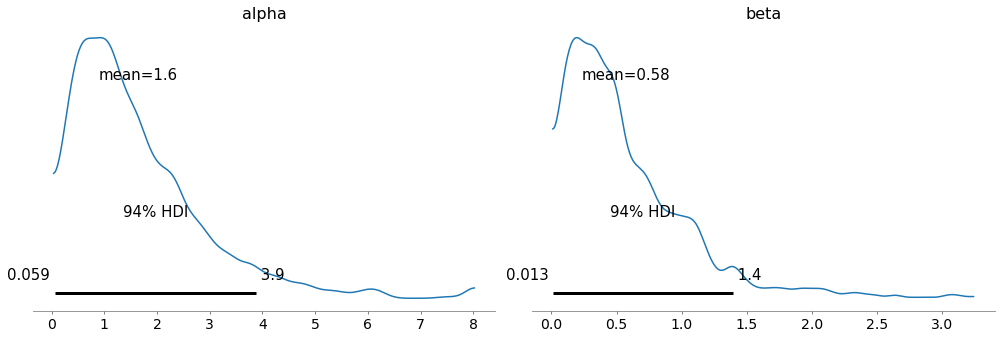

In [89]:
az.plot_posterior(trace7, var_names=['alpha', 'beta'])

In [147]:
import numpy as np
from scipy.stats import expon
from empiricaldist import Pmf

qs = np.linspace(0.1, 10, 100)
ps = expon(scale=1).pdf(qs)

prior_alpha = Pmf(ps, qs)
prior_alpha.index.name = 'alpha'
prior_alpha.shape

(100,)

<AxesSubplot:xlabel='alpha'>

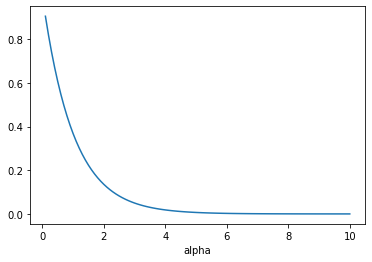

In [148]:
prior_alpha.plot()

In [149]:
qs = np.linspace(0.1, 9, 90)
ps = expon(scale=1).pdf(qs)
prior_beta = Pmf(ps, qs)
prior_beta.index.name = 'beta'
prior_beta.shape

(90,)

<AxesSubplot:xlabel='beta'>

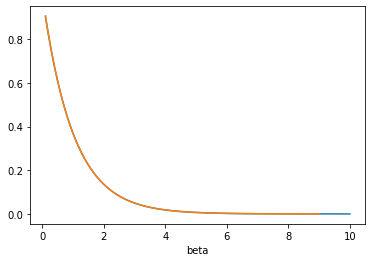

In [150]:
prior_alpha.plot()
prior_beta.plot()

In [152]:
from utils import make_joint, normalize

PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')

hyper = PA * PB
hyper.shape

(100, 90)

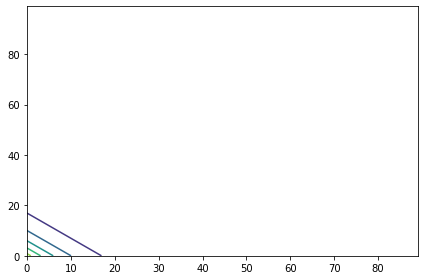

In [153]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(hyper))

In [154]:
from scipy.stats import poisson

mus = np.linspace(0.1, 12, 80)
ks = 5, 3

M, K = np.meshgrid(mus, ks)
like_mu = poisson(M).pmf(K).prod(axis=0)
like_mu.shape

(80,)

In [155]:
A, B, M = np.meshgrid(prior_alpha.qs, prior_beta.qs, mus, indexing='ij')
A.shape

(100, 90, 80)

In [156]:
A.mean()

5.050000000000001

In [157]:
B.mean()

4.55

In [158]:
M.mean()

6.05

In [171]:
from scipy.stats import gamma

prior = gamma(A, B).pdf(M) * hyper.reshape((100, 90, 1))
prior.shape

(100, 90, 80)

<AxesSubplot:>

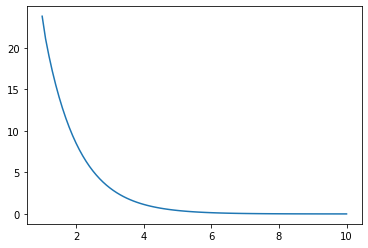

In [172]:
prior_a = Pmf(prior.sum(axis=(1,2)), prior_alpha.qs)
prior_a.plot()

<AxesSubplot:>

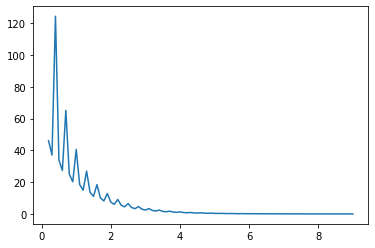

In [173]:
prior_b = Pmf(prior.sum(axis=(0,2)), prior_beta.qs)
prior_b.plot()

<AxesSubplot:>

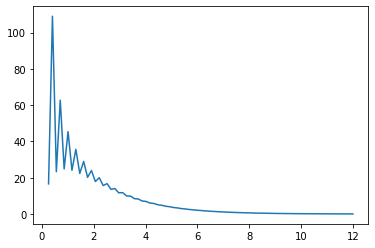

In [174]:
prior_m = Pmf(prior.sum(axis=(0,1)), mus)
prior_m.plot()

In [175]:
posterior = prior * like_mu
posterior /= posterior.sum()

<ipython-input-175-889671aa54f4>:2: RuntimeWarning: invalid value encountered in true_divide
  posterior /= posterior.sum()


<AxesSubplot:>

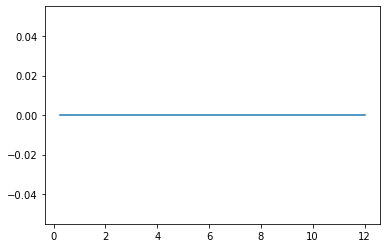

In [176]:
ps = posterior.sum(axis=(0, 1))
marginal_mu = Pmf(ps, mus)
marginal_mu.plot()

1.5095740795170893

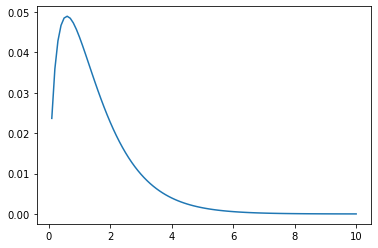

In [168]:
ps = posterior.sum(axis=(1, 2))
marginal_alpha = Pmf(ps, prior_alpha.qs)
marginal_alpha.plot()
marginal_alpha.mean()

0.8020955385765

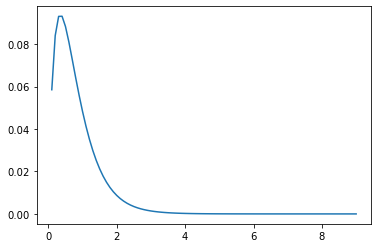

In [166]:
ps = posterior.sum(axis=(0, 2))
marginal_beta = Pmf(ps, prior_beta.qs)
marginal_beta.plot()
marginal_beta.mean()

In [9]:
import pymc3 as pm

with pm.Model() as model7:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1,1])
    trace7 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


## More background

But let's take advantage of more information.  Here are the results from the most recent Stanley Cup finals.
For games that went into overtime, I included only goals scored during regulation play.

In [ ]:
data = dict(BOS13 = [3, 1, 2, 5, 1, 2],
            CHI13 = [3, 1, 0, 5, 3, 3],
            NYR14 = [2, 4, 0, 2, 2],
            LAK14 = [2, 4, 3, 1, 2],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 2, 1, 4, 1],
            PIT16 = [3, 1, 2, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            STL19 = [2, 2, 2, 4, 2, 1, 4],
            BOS19 = [4, 2, 7, 2, 1, 5, 1],
            DAL20 = [4, 2, 2, 4, 2, 0],
            TBL20 = [1, 3, 5, 4, 2, 2],
            MTL21 = [1, 1, 3, 2, 0],
            TBL21 = [5, 3, 6, 2, 1])

Here's how we can get the data into the model.

In [ ]:
with pm.Model() as model8:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace8 = pm.sample(500)

Here's the graph representation of the model:

In [ ]:
viz = pm.model_to_graphviz(model8)
viz

In [ ]:
# How to save a graphviz image
#viz.format = 'png'
#viz.view(filename='model8', directory='./')

And here are the results.

In [ ]:
with model8:
    az.plot_trace(trace8, var_names=['alpha', 'beta'])

Here are the posterior means for the hyperparameters.

In [ ]:
sample_post_alpha = trace8['alpha']
sample_post_alpha.mean()

In [ ]:
sample_post_beta = trace8['beta']
sample_post_beta.mean()

So in case you were wondering how I chose the parameters of the gamma distribution in the first notebook.
That's right -- time travel.

In [ ]:
sample_post_mu_TBL21 = trace8['mu_TBL21']
sample_post_mu_MTL21 = trace8['mu_MTL21']
sample_post_mu_TBL21.mean(), sample_post_mu_MTL21.mean()

In [ ]:
plot_kde(sample_post_mu_TBL21, label='TBL21')
plot_kde(sample_post_mu_MTL21, label='MTL21')
decorate_rate()

Here's the updated chance that Tampa Bay is the better team.

In [ ]:
(sample_post_mu_TBL21 > sample_post_mu_MTL21).mean()